<a href="https://colab.research.google.com/github/atlaie/Case-Studies/blob/main/Custom_Spiking_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nengo-dl[docs]

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot
import seaborn as sns

|#####################Building network (50%)                     | ETA: 0:00:00

/usr/local/lib/python3.9/dist-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               


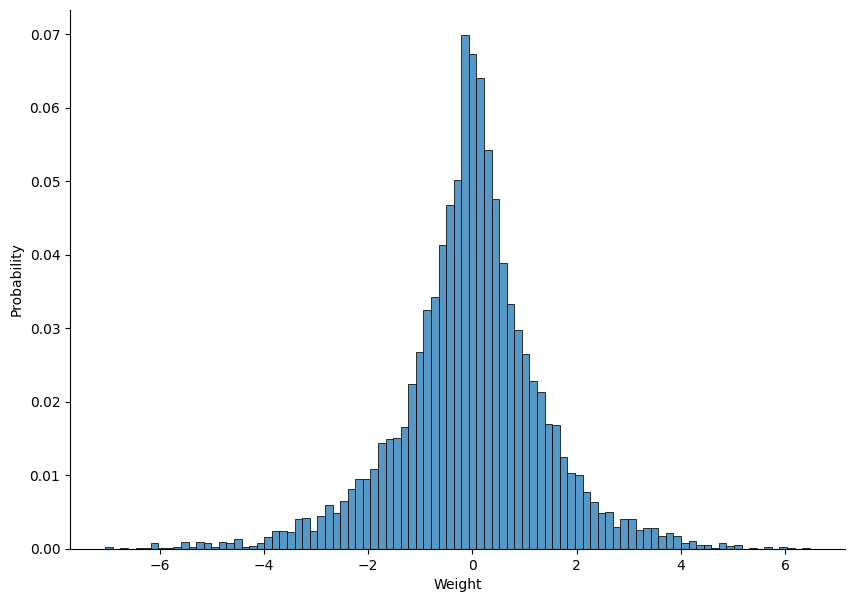

In [2]:
import nengo_dl
from nengo_dl.graph_optimizer import noop_planner

# In this example, a population of LIF neurons is recurrently connected.
# The connection strength (weight) for any two neurons is given by a Laplacian distribution. 
# Moreover, with a fixed probability, some neurons are set to be inhibitory.

rng = np.random.RandomState(seed=100)
inhibitory_pre = 0.2  # 20% inhibitory connections
sparsity_pre = 0.3  # 80% probability of being connected
# inhibitory_post = 0.1  # 20% inhibitory connections
# sparsity_post = 0.6  # 80% probability of being connected
n_neurons = 100
maxRate = 100
tau = 0.01  # synaptic time constant on recurrent connection
t_int = 0.02  # length of time for input presentation

with nengo.Network() as model:
    nengo_dl.configure_settings(planner=noop_planner)
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([maxRate])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    # model.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    model.config[nengo.Connection].synapse = None

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # Neural ensemble.
    ensA = nengo.Ensemble(n_neurons, 1, neuron_type = nengo.LIF(amplitude=1/maxRate))

    nengo.Connection(inp, ensA.neurons, transform = nengo_dl.dists.Glorot())

    # Specify connectivity and make the recurrence.
    pre_post = np.random.laplace(size = (n_neurons, n_neurons))
    pre_post[rng.rand(n_neurons, n_neurons) <= inhibitory_pre] *= -1
    pre_post[rng.rand(n_neurons, n_neurons) <= sparsity_pre] *= 0

    recurr = nengo.Connection(ensA.neurons, ensA.neurons, transform=pre_post, synapse=tau)

    # dense linear readout
    out = nengo.Node(size_in=10)
    nengo.Connection(ensA, out, transform=nengo_dl.dists.Glorot(), synapse=None)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")
    ens_probe = nengo.Probe(ensA.neurons)


minibatch_size = 256
sim = nengo_dl.Simulator(model, minibatch_size=minibatch_size)
weights_pre = sim.data[recurr].weights
# weights_post = sim.data[conn_post].weights
fig, ax = plt.subplots(figsize=(10,7))
weights = weights_pre.ravel()
sns.histplot(data = weights[weights!=0], stat = 'probability', kde = False, lw = 2)
plt.xlabel('Weight')
sns.despine()

In [3]:
from urllib.request import urlretrieve
import tensorflow as tf
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 10
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print("Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],)

11490434/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.9/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (10000) is not evenly divisible by Simulator.minibatch_size (256); input data will be truncated.
  warnings.warn(


Accuracy before training: 0.10196314007043839


In [4]:
# run training
sim.compile(
    optimizer=tf.optimizers.Adam(),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
)
sim.fit(train_images, {out_p: train_labels}, epochs=10)

sim.compile(loss={out_p_filt: classification_accuracy})
print("Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (60000) is not evenly divisible by Simulator.minibatch_size (256); input data will be truncated.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


234/234 [==============================] - 13s 20ms/step - loss: 0.5298 - out_p_loss: 0.5298
Epoch 2/10
234/234 [==============================] - 5s 22ms/step - loss: 0.2569 - out_p_loss: 0.2569
Epoch 3/10
234/234 [==============================] - 6s 25ms/step - loss: 0.2190 - out_p_loss: 0.2190
Epoch 4/10
234/234 [==============================] - 5s 21ms/step - loss: 0.1962 - out_p_loss: 0.1962
Epoch 5/10
234/234 [==============================] - 6s 24ms/step - loss: 0.1844 - out_p_loss: 0.1844
Epoch 6/10
234/234 [==============================] - 6s 24ms/step - loss: 0.1759 - out_p_loss: 0.1759
Epoch 7/10
234/234 [==============================] - 5s 20ms/step - loss: 0.1632 - out_p_loss: 0.1632
Epoch 8/10
234/234 [==============================] - 4s 19ms/step - loss: 0.1525 - out_p_loss: 0.1525
Epoch 9/10
234/234 [==============================] - 5s 23ms/step - loss: 0.1441 - out_p_loss: 0.1441
Epoch 10/10
234/234 [==============================] - 5s 20ms/step - loss: 0.1443 

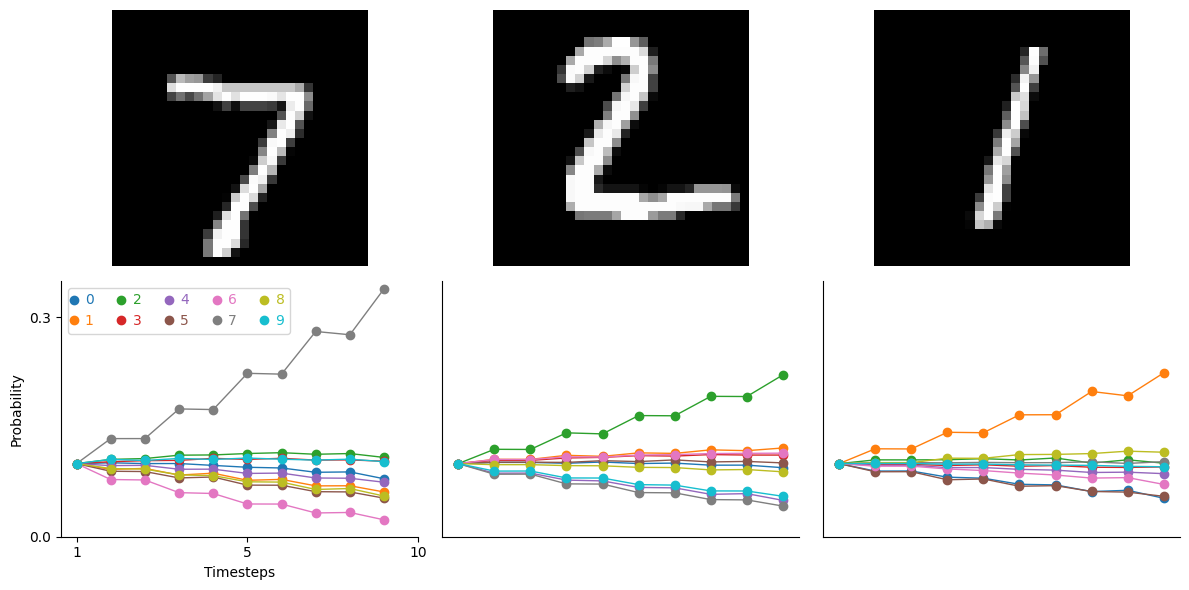

In [30]:
data = sim.predict(test_images[:minibatch_size])
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12,6))

for ii in range(3):
    axi = ax[0, ii]
    axi.imshow(test_images[ii, 0].reshape((28, 28)), cmap="gray")
    axi.axis("off")

    axi = ax[1, ii]
    axi.plot(tf.nn.softmax(data[out_p_filt][ii]), marker = 'o', lw = 1)
    axi.set_ylim([0, 0.35])
    if ii == 0:
        axi.set_xlabel("Timesteps")
        axi.set_ylabel("Probability")
        axi.set_yticks([0, 0.3])
        axi.set_xticks(np.arange(0, 11, 5))
        axi.set_xticklabels(['1','5','10'])
        axi.legend([str(i) for i in range(10)], ncol = 5, handlelength = 0, labelcolor = 'linecolor', loc = 'upper left')

    else:
        axi.set_yticks([])
        axi.set_xticks([])
sns.despine()
plt.tight_layout()
sim.close()